In [1]:
import scipy.io as sio
import numpy as np
import cv2
import copy
import sys
from utils import gauss_normal_generate, cvt2HeatmapImg
from utils import cvt2HeatmapMatrix, point_generate, interval_list_generate
import torch.utils.data as data
import torch
import random
from utils import interval_list_generate
import matplotlib.pyplot as plt



# 데이터 형식 :
# ------------

# SynthText.zip (크기 = 42074172 바이트 (41GB))에는 858,750 합성이 포함됩니다.
# 장면 이미지 파일 (.jpg)은 200 개의 디렉토리로 분할됩니다. 
# 7,266,866 개의 단어 인스턴스 및 28,971,487 개의 문자.

# Ground-truth 주석은 "gt.mat"파일 (Matlab 형식)에 포함되어 있습니다.
# "gt.mat"파일에는 각각 크기가 1x858750 인 다음 셀 배열이 포함되어 있습니다.

#   1. imnames : 이미지 파일의 이름

#   2. wordBB : 각 이미지에 대한 단어 수준 경계 상자,
#                 2x4xNWORDS_i 크기의 텐서, 여기서 :
#                    -첫 번째 차원은 x와 y에 대해 각각 2입니다.
#                    -두 번째 차원은 4 점에 해당합니다.
#                      (시계 방향, 왼쪽 상단부터 시작)
#                    -크기 NWORDS_i의 세 번째 차원은
#                       i_ 번째 이미지의 단어 수.

#   3. charBB : 문자 수준 경계 상자,
#                각각 2x4xNCHARS_i 크기의 텐서로 표시됩니다.
#                (형식은 위의 wordBB와 동일)

#   4. txt : 각 이미지에 포함 된 텍스트 문자열 (문자 배열).
               
#                동일한 "인스턴스"에 속하는 단어, 즉,
#                같은 영역에서 같은 글꼴, 색상,
#                왜곡 등은 함께 그룹화됩니다. 인스턴스
#                경계는 줄 바꿈 문자로 구분됩니다 (ASCII : 10).

#                "단어"는 공백이 아닌 연속 된 하위 문자열입니다.
#                문자.

#                "문자"는 공백이 아닌 문자로 정의됩니다.

    

In [2]:
## mat파일은 3가지 컬럼으로 구성
# charBB
# txt
# imnames
temp = sio.loadmat('/data/data/synthtext/SynthText/gt.mat')
## 불러온 자료형태는 dict형
print(len(temp))
print(type(temp))


7
<class 'dict'>


In [3]:
print(temp.keys())

dict_keys(['__header__', '__version__', '__globals__', 'charBB', 'wordBB', 'imnames', 'txt'])


In [4]:
print(len(temp['charBB']))
print(type(temp['charBB']))
print(temp['charBB'].shape)
print(len(temp['charBB'][0]),type(temp['charBB'][0]))


print(temp['charBB'][0].shape)
print(temp['charBB'][0][0].shape)
print(temp['imnames'][0][0])

1
<class 'numpy.ndarray'>
(1, 858750)
858750 <class 'numpy.ndarray'>
(858750,)
(2, 4, 54)
['8/ballet_106_0.jpg']


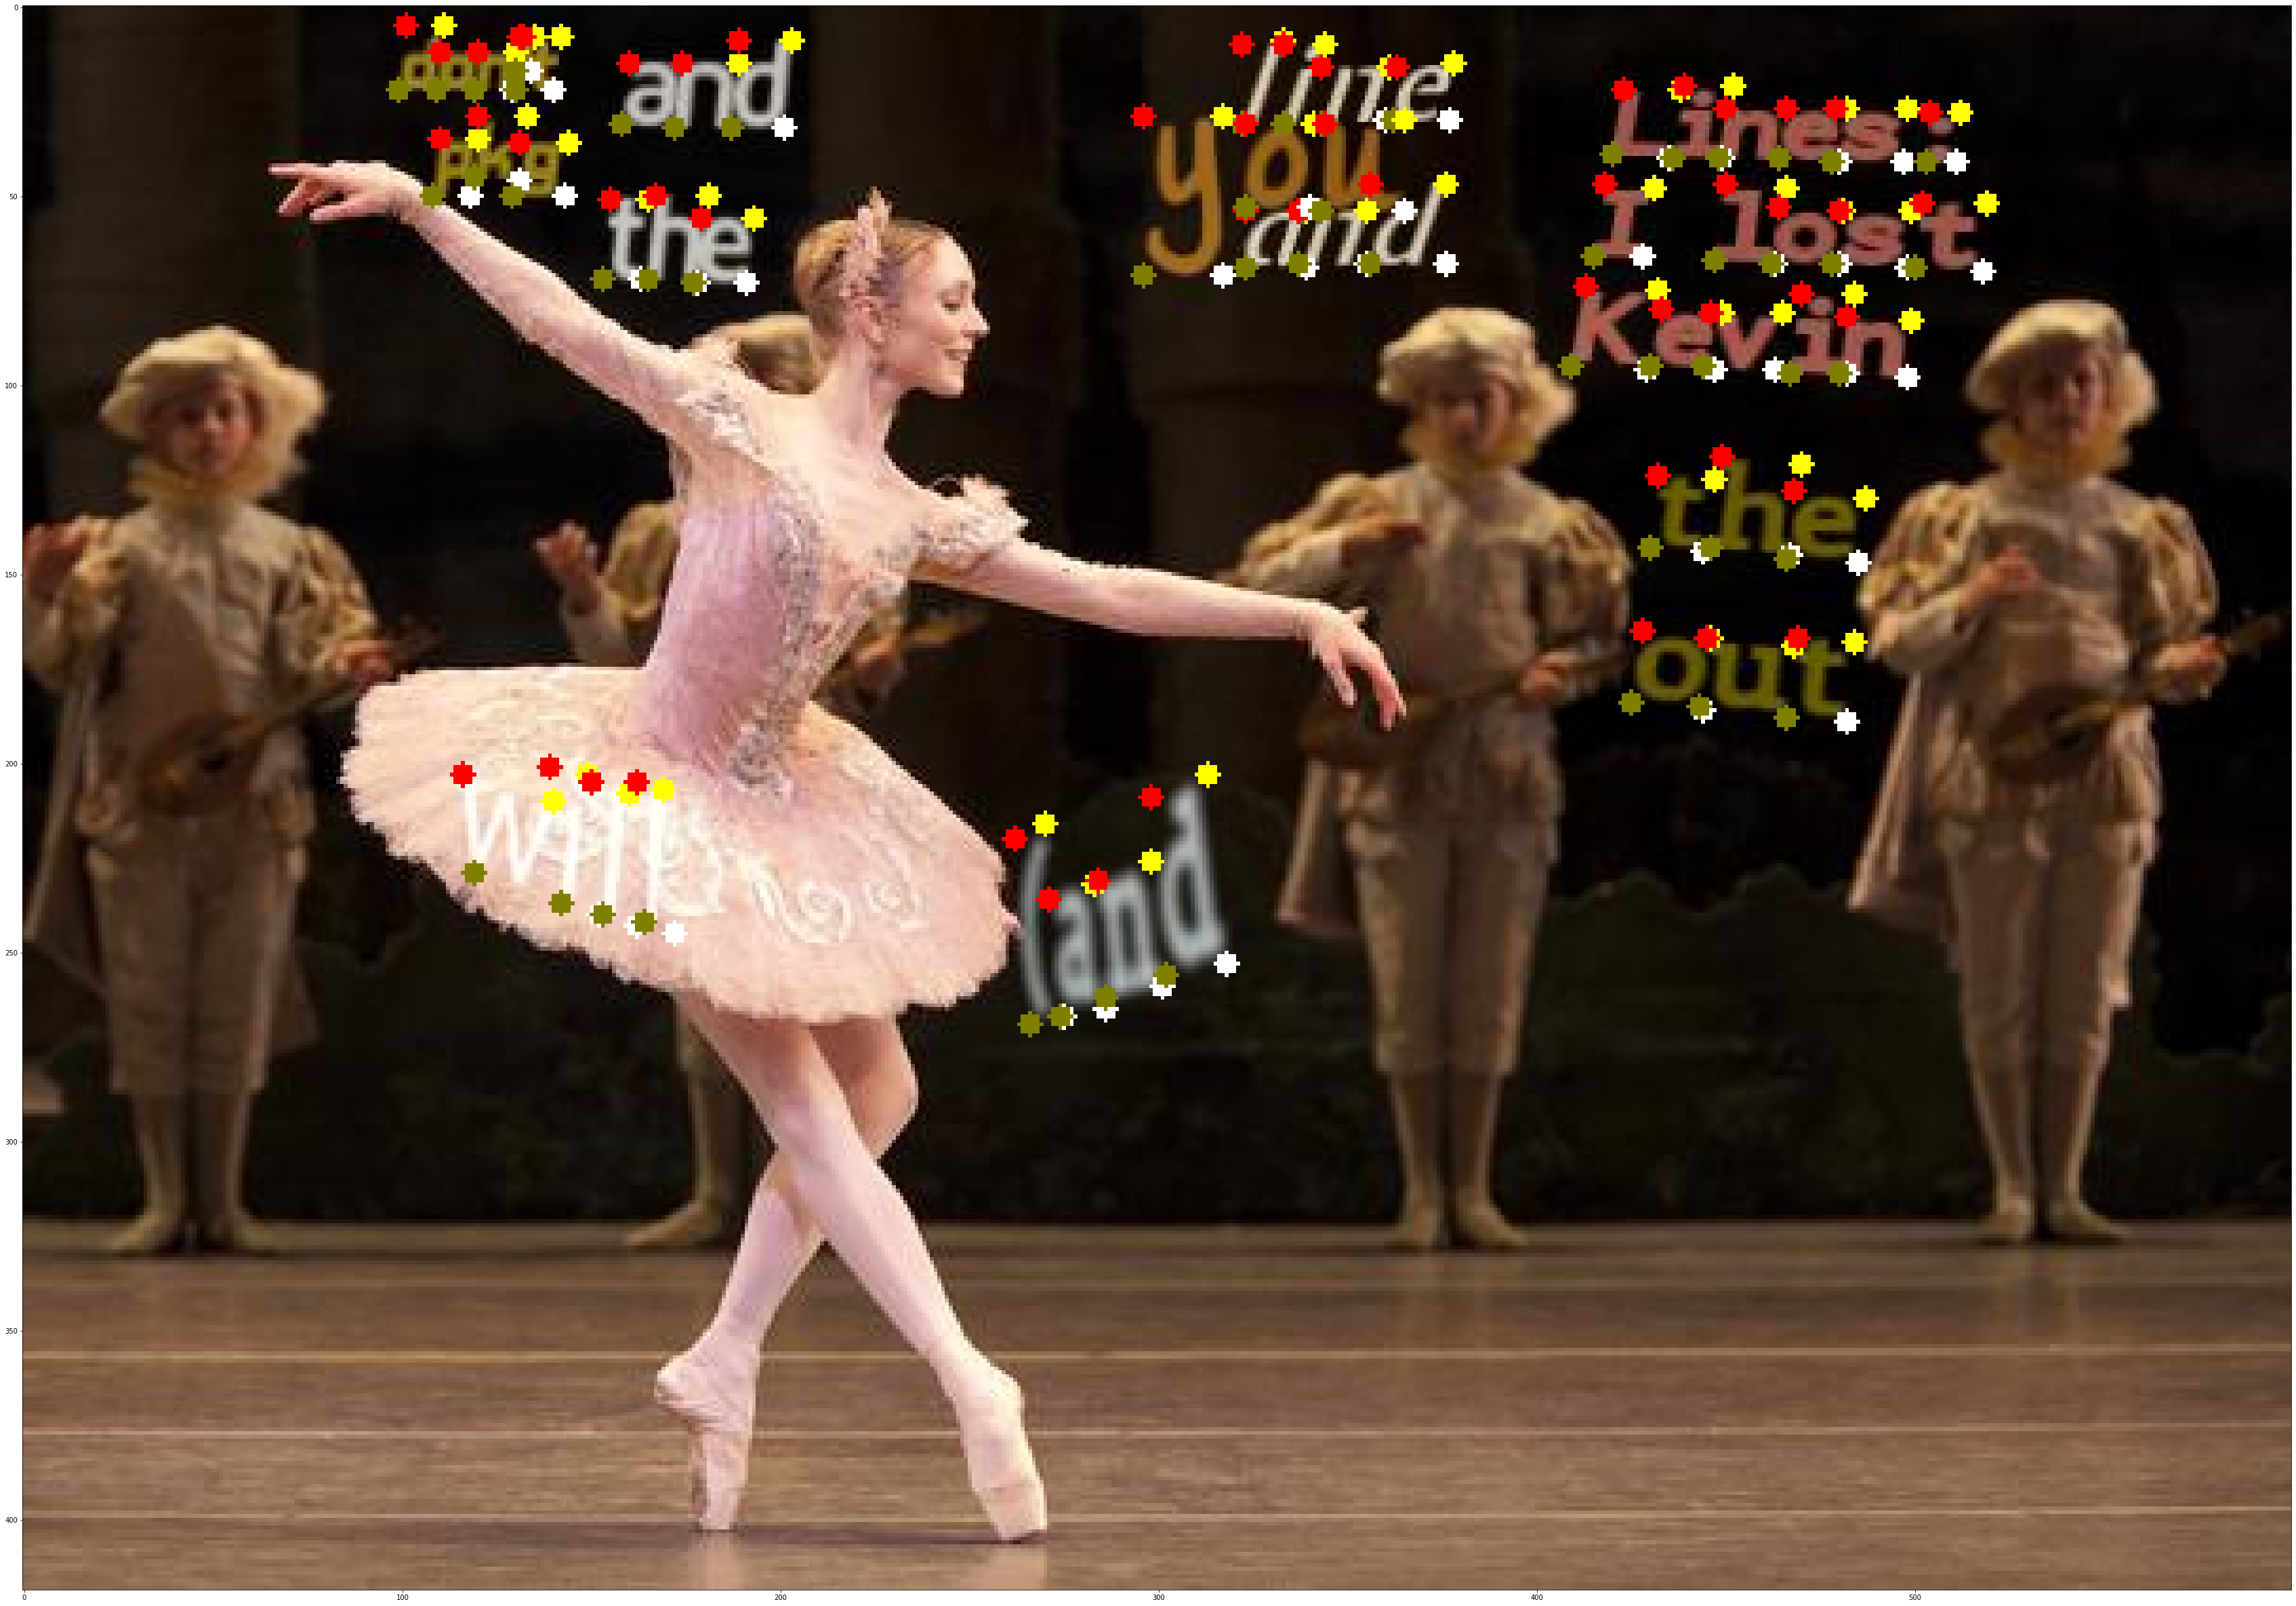

In [25]:
img_dir_path ='/data/data/synthtext/SynthText/'
img_file_path = img_dir_path+str(temp['imnames'][0][0])[2:-2]

## (419, 600, 3)
image = cv2.imread(img_file_path)


cor_list = temp['charBB'][0][0]

cor_list.shape[2]

char_number = cor_list.shape[2]
for i in range(char_number):
    
    ## 캐릭터 좌표
    image = cv2.circle(image,(int(cor_list[0][0][i]),int(cor_list[1][0][i])),3,(0,0,255),-1)
    image = cv2.circle(image,(int(cor_list[0][1][i]),int(cor_list[1][1][i])),3,(0,255,255),-1)
    image = cv2.circle(image,(int(cor_list[0][2][i]),int(cor_list[1][2][i])),3,(255,255,255),-1)
    image = cv2.circle(image,(int(cor_list[0][3][i]),int(cor_list[1][3][i])),3,(0,127,127),-1)


plt.figure(figsize = (60,60))
## rgb = bgr[...,::-1].copy()
plt.imshow(image[...,::-1])

In [6]:
print(box_point_xy.shape,box_point_xy)
#[423, 438, 435, 420] [22, 22, 40, 39]

(4, 54) [[423.16126397 439.60847343 450.66887979 466.31976402 479.76190495
  504.59927448 418.80489444 450.13965942 464.16775197 480.46891089
  502.46437709 413.02373632 433.01396211 446.7222192  470.28467827
  482.51674486 116.52285438 139.51408587 150.7448586  162.03366629
  322.84717946 333.54881536 343.28386485 363.07416389 323.48968759
  337.98503283 356.66355903 160.48517048 174.1707753  189.64454066
  155.7637383  167.45490471 179.63644201 262.2183876  271.75848874
  284.05396524 298.26103738 432.8464733  449.15387392 468.07231897
  428.11482147 445.61538159 469.24565878 296.86441324 323.6603118
  344.09880401 101.14677814 110.45423597 120.54555495 131.18342618
  132.20545124 110.01673682 120.83144568 131.35885673]
 [438.2997574  452.61288403 466.31976402 482.22585715 498.3934528
  512.20555863 431.88338084 466.11639619 481.73414937 499.62012025
  519.36789779 432.51717267 449.23571387 465.73425964 484.45139112
  499.59056304 140.27413679 149.59811175 160.13352083 169.59504507
 

In [7]:


print(box_point_4_point.shape,box_point_4_point)

(4, 54) [[ 22.26958901  21.60559248  27.0241972   27.25747678  27.45783459
   28.73896576  47.91255579  47.80732383  53.77711568  54.24219042
   52.00169325  74.79043429  80.45929285  81.04748707  76.11658669
   82.58335942 203.67278213 201.2743445  205.59358622 205.51198143
   10.06536976  10.82312635  16.77203865  16.31842372  54.80444433
   54.66492     47.33822371  15.08534083  15.18716407   9.62607092
   51.06813224  50.18928243  56.16019366 220.78902143 236.08062638
  231.69267533 209.73652786 124.25352842 119.99631725 128.73732717
  165.78411123 167.31764153 167.05531699  29.97351822  31.5116502
   31.14650552   5.88513488  12.51324147  12.57920537   8.21515307
    8.21998849  35.66412031  29.17945741  36.00660903]
 [ 22.46075572  21.76391911  27.25747678  27.49456029  27.73554156
   28.85582217  48.25428361  48.21714995  54.27828788  54.78857757
   52.4595556   75.57743634  81.15533616  81.86325615  76.681392
   83.31596322 210.04771309 203.83983042 208.00417391 207.41791524
  

In [19]:
cor_list = temp['charBB'][0][0]

cor_list.shape[2]

char_number = cor_list.shape[2]
for i in range(char_number):
    x = []
    y = []
    for index in range(4):
        x.append(copy.deepcopy(int(cor_list[0][index][i])))
        y.append(copy.deepcopy(int(cor_list[1][index][i])))
        print(i,x,y)
    

0 [423] [22]
0 [423, 438] [22, 22]
0 [423, 438, 435] [22, 22, 40]
0 [423, 438, 435, 420] [22, 22, 40, 39]
1 [439] [21]
1 [439, 452] [21, 21]
1 [439, 452, 449] [21, 21, 40]
1 [439, 452, 449, 436] [21, 21, 40, 40]
2 [450] [27]
2 [450, 466] [27, 27]
2 [450, 466, 464] [27, 27, 40]
2 [450, 466, 464, 448] [27, 27, 40, 40]
3 [466] [27]
3 [466, 482] [27, 27]
3 [466, 482, 480] [27, 27, 41]
3 [466, 482, 480, 464] [27, 27, 41, 40]
4 [479] [27]
4 [479, 498] [27, 27]
4 [479, 498, 497] [27, 27, 41]
4 [479, 498, 497, 478] [27, 27, 41, 41]
5 [504] [28]
5 [504, 512] [28, 28]
5 [504, 512, 511] [28, 28, 41]
5 [504, 512, 511, 503] [28, 28, 41, 41]
6 [418] [47]
6 [418, 431] [47, 48]
6 [418, 431, 428] [47, 48, 66]
6 [418, 431, 428, 415] [47, 48, 66, 66]
7 [450] [47]
7 [450, 466] [47, 48]
7 [450, 466, 463] [47, 48, 68]
7 [450, 466, 463, 447] [47, 48, 68, 67]
8 [464] [53]
8 [464, 481] [53, 54]
8 [464, 481, 480] [53, 54, 68]
8 [464, 481, 480, 462] [53, 54, 68, 68]
9 [480] [54]
9 [480, 499] [54, 54]
9 [480, 499